In [1]:
# Cell 1 — Setup & load
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Path to your input design CSV (edit as needed)
DESIGN_CSV = "design_data/ExRunBending1/experiment_set_bending1_with_metrics.csv"  # <-- put your file path here

# Load
design_df = pd.read_csv(DESIGN_CSV)

# Normalize a "design" column from "Prototype ID" for convenience
if "design" not in design_df.columns:
    if "Prototype ID" in design_df.columns:
        design_df["design"] = design_df["Prototype ID"].astype(str)
    else:
        raise ValueError("Expected a 'Prototype ID' column in the input CSV.")

# Quick peek
display(design_df.head())


,Prototype ID,export_folder,config_csv,use_linear_fast,arc_length_min,arc_length_max,arc_length_ratio,design
0,bending0,prototype_models,datasets/configs/bending0.csv,False,129.745832,129.745832,1.000000,bending0
1,bending1,prototype_models,datasets/configs/bending1.csv,False,127.588720,133.003518,1.042825,bending1
2,bending2,prototype_models,datasets/configs/bending2.csv,False,125.416493,136.556281,1.088823,bending2
3,bending3,prototype_models,datasets/configs/bending3.csv,False,123.523455,140.356174,1.136679,bending3
4,bending4,prototype_models,datasets/configs/bending4.csv,False,121.314149,144.465494,1.190000,bending4


In [2]:
# Cell 2 — Helpers: numeric ordering & gradient colors
def _numeric_suffix(label: str):
    """Return trailing integer in a label (e.g., 'bending12' -> 12), or None."""
    m = re.search(r'(\d+)$', str(label))
    return int(m.group(1)) if m else None

def _order_labels(labels):
    """Order labels by trailing numeric suffix if present, else alphabetically."""
    pairs = [(lab, _numeric_suffix(lab)) for lab in labels]
    if any(n is not None for _, n in pairs):
        return [lab for lab, _ in sorted(pairs, key=lambda t: (float('inf') if t[1] is None else t[1], str(t[0])))]
    return sorted(labels)

def _colors_for_labels(labels, cmap_name="viridis", span=(0.1, 0.9)):
    """
    Map labels to a gradient along a matplotlib colormap, ordered by numeric suffix if present.
    span: (low, high) portion of the colormap to improve contrast.
    """
    cmap = plt.get_cmap(cmap_name)
    ordered = _order_labels(labels)
    rank = {lab: i for i, lab in enumerate(ordered)}
    n = len(labels)
    xs = np.array([(span[0] + span[1]) / 2.0]) if n == 1 else np.linspace(span[0], span[1], n)
    return [cmap(xs[rank[lab]]) for lab in labels]


In [3]:
# Cell 3 — Plot function
def plot_input_designs_metric(df: pd.DataFrame, metric: str, cmap_name: str = "viridis",
                              sort: str = "numeric", annotate: bool = True,
                              figsize=(9,5), save_path: str | None = None) -> None:
    """
    Plot all designs for a selected INPUT metric from the input-design CSV.
    
    Parameters
    ----------
    df : DataFrame
        Must contain columns: 'design' and the selected metric (e.g., 'arc_length_ratio').
    metric : str
        Column name to plot (e.g., 'arc_length_ratio', 'arc_length_min', 'arc_length_max').
    cmap_name : str
        Matplotlib colormap name for the gradient (e.g., 'viridis', 'plasma', 'magma', 'cividis').
    sort : {'numeric','alpha','value'}
        - 'numeric': x-axis ordered by trailing number in label (bending0, bending1, …).
        - 'alpha'  : alphabetical by label.
        - 'value'  : sorted by metric value (descending).
    annotate : bool
        If True, prints the value on top of each bar.
    figsize : tuple
        Figure size.
    save_path : str | None
        If provided, saves the figure to this path.
    """
    if "design" not in df.columns:
        print("[WARN] 'design' column not found.")
        return
    if metric not in df.columns:
        print(f"[WARN] Metric '{metric}' not found.")
        return

    sub = df[["design", metric]].dropna()
    if sub.empty:
        print("[WARN] No data to plot for the selected metric.")
        return

    # Decide x-order
    labels = sub["design"].tolist()
    if sort == "value":
        sub = sub.sort_values(metric, ascending=False)
        labels_sorted = sub["design"].tolist()
    elif sort == "alpha":
        labels_sorted = sorted(labels)
        sub = sub.set_index("design").loc[labels_sorted].reset_index()
    elif sort == "inverse_numeric":
        # numeric order but reversed
        labels_sorted = list(reversed(_order_labels(labels)))
        sub = sub.set_index("design").loc[labels_sorted].reset_index()
    else:  # 'numeric'
        labels_sorted = _order_labels(labels)
        sub = sub.set_index("design").loc[labels_sorted].reset_index()

    # Colors follow numeric order, even if we chose 'value' sorting
    colors = _colors_for_labels(labels_sorted, cmap_name=cmap_name)

    # Plot
    plt.figure(figsize=figsize)
    x = np.arange(len(sub))
    plt.bar(x, sub[metric].to_numpy(), color=colors, edgecolor="none")
    plt.xticks(x, sub["design"], rotation=30, ha="right")

    plt.title(f"{metric} across input designs")
    plt.xlabel("design")
    plt.ylabel(metric)

    if annotate:
        for xi, yi in zip(x, sub[metric].to_numpy()):
            plt.text(xi, yi, f"{yi:.3g}", ha="center", va="bottom", fontsize=9)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()


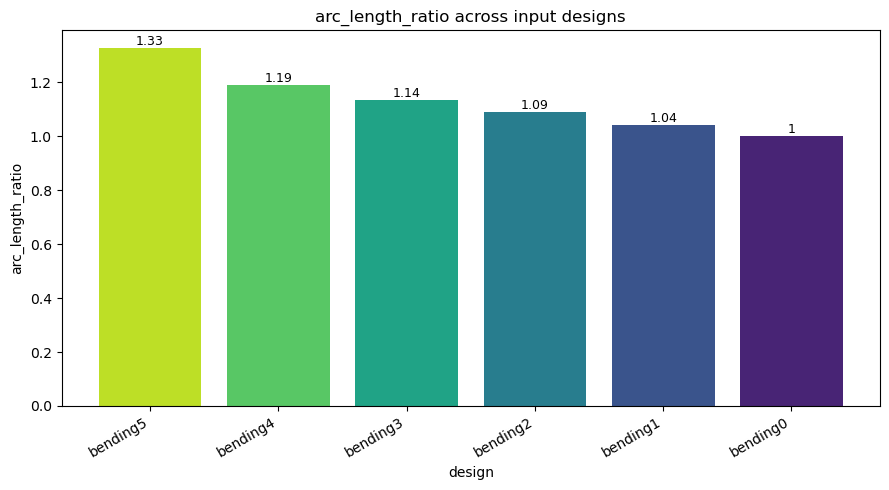

In [4]:
# Cell 4 — Example calls
# Plot arc_length_ratio with numeric-order gradient
plot_input_designs_metric(design_df, metric="arc_length_ratio", cmap_name="viridis", sort="inverse_numeric")

# Try a different theme and sort by value
# plot_input_designs_metric(design_df, metric="arc_length_ratio", cmap_name="plasma", sort="value")

# Plot arc_length_min / arc_length_max similarly:
# plot_input_designs_metric(design_df, metric="arc_length_min", cmap_name="magma", sort="numeric")
# plot_input_designs_metric(design_df, metric="arc_length_max", cmap_name="cividis", sort="numeric")
